In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [119]:
# Read the CSV file. Adjust the filename and separator if needed.
df = pd.read_csv("../../../Results_no_oversampling.csv", sep=';')

# Inspect the DataFrame (optional)
print(df.head())

  Model                                      Baseline Timepoint  \
0   PCA                                Recall@5: 0.00        S1   
1   PCA                      MSE: 0.05799181014299393        S1   
2   PCA            Mean Clonotype Activation: -0.0110        S1   
3   PCA  Mean Clonotype Activation Predicted: -0.0216        S1   
4   PCA                                           NaN        S1   

                               Timepoint LinReg  \
0                                Recall@5: 0.20   
1                     MSE: 0.033736078214546564   
2     MSE- Clonotype mean: 0.033736078214546564   
3            Mean Clonotype Activation: -0.0136   
4  Mean Clonotype Activation Predicted: -0.0376   

                                  Timepoint GBR  \
0                                Recall@5: 0.20   
1                      MSE: 0.04077866010989528   
2      MSE- Clonotype mean: 0.04077866010989528   
3            Mean Clonotype Activation: -0.0136   
4  Mean Clonotype Activation Predic

In [120]:
# Melt the DataFrame so that "Baseline" and "Timepoint LinReg" become rows.
df_long = df.melt(id_vars=["Model", "Timepoint"], 
                  var_name="Method", 
                  value_name="MetricData")

# Define a function that parses each metric string.
# It uses the "Timepoint" value to remove the "for <Timepoint>" part.
def parse_metric_row(row):
    cell = row["MetricData"]
    timepoint = row["Timepoint"]
    if not isinstance(cell, str):
        return pd.Series({"Metric": None, "Value": None})
    # Remove the "for <Timepoint>" substring, e.g., " for S1"
    pattern_for = fr"\s+for\s+{timepoint}"
    cell_clean = re.sub(pattern_for, "", cell)
    # Remove the "in <Timepoint>" substring, e.g., " for S1"
    pattern_in = fr"\s+in\s+{timepoint}"
    cell_clean = re.sub(pattern_in, "", cell)
    # Also remove any occurrence of " (<timepoint>)", e.g., " (S1)"
    pattern_bracket = fr"\s*\({timepoint}\)"
    cell_clean = re.sub(pattern_bracket, "", cell_clean)
    
    
    # Split the cleaned string on the colon to separate the metric name and value.
    parts = cell_clean.split(":")
    if len(parts) == 2:
        metric_text = parts[0].strip()
        try:
            value = float(parts[1].strip())
        except ValueError:
            value = None
        return pd.Series({"Metric": metric_text, "Value": value})
    else:
        return pd.Series({"Metric": None, "Value": None})
    
# Apply the parsing function row-wise to get new columns.
df_long = df_long.join(df_long.apply(parse_metric_row, axis=1))

# Optionally, drop the original "MetricData" column.
df_long.drop(columns=["MetricData"], inplace=True)

print(df_long.head())

  Model Timepoint    Method                               Metric     Value
0   PCA        S1  Baseline                             Recall@5  0.000000
1   PCA        S1  Baseline                                  MSE  0.057992
2   PCA        S1  Baseline            Mean Clonotype Activation -0.011000
3   PCA        S1  Baseline  Mean Clonotype Activation Predicted -0.021600
4   PCA        S1  Baseline                                 None       NaN


In [121]:
df_long['Metric'].unique()
df_long = df_long.dropna()

In [122]:
drop_values = ['Mean Clonotype Activation', 'Mean Clonotype Activation Predicted', 'MSE- Mean']
df_long = df_long[~df_long['Metric'].isin(drop_values)]

In [123]:
df_long

,Model,Timepoint,Method,Metric,Value
0,PCA,S1,Baseline,Recall@5,0.000000
1,PCA,S1,Baseline,MSE,0.057992
7,PCA,T1,Baseline,Recall@5,0.000000
8,PCA,T1,Baseline,MSE,0.113631
14,deepTCR,S1,Baseline,Recall@5,0.000000
...,...,...,...,...,...
973,mvTCR + deepTCR + PCA,T1,OT RF,Recall@5,0.800000
974,mvTCR + deepTCR + PCA,T1,OT RF,MSE,0.010160
975,mvTCR + deepTCR + PCA,T1,OT RF,MSE- Clonotype mean,0.010160
978,mvTCR + deepTCR + PCA,T1,OT RF,MSE for bottom 25% (low-responding clones),0.007900


In [124]:
df = df_long

In [125]:
# We pick a single blue for Baseline
baseline_color = "#1f77b4"  # standard matplotlib 'blue'

# Create 3 greens for Donor
greens = sns.color_palette("Greens", 3)
# Create 3 oranges for OT
turquoises = sns.color_palette("Greys", 3)
# Create 3 red for OT
reds = sns.color_palette("Oranges", 3)

color_dict = {
    "Baseline": baseline_color,

    # Donor methods (greens)
    "Timepoint LinReg": greens[0],
    "Timepoint GBR":   greens[1],
    "Timepoint RF":    greens[2],

    # Donor methods (greens)
    "Donor LinReg": turquoises[0],
    "Donor GBR":   turquoises[1],
    "Donor RF":    turquoises[2],

    # OT methods (oranges)
    "OT LinReg": reds[0],
    "OT GBR":   reds[1],
    "OT RF":    reds[2]
}

In [126]:
df_recall = df[df['Metric'] == 'Recall@5']

df_S1 = df_recall[df_recall['Timepoint'] == 'S1']
df_T1 = df_recall[df_recall['Timepoint'] == 'T1']

/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureW

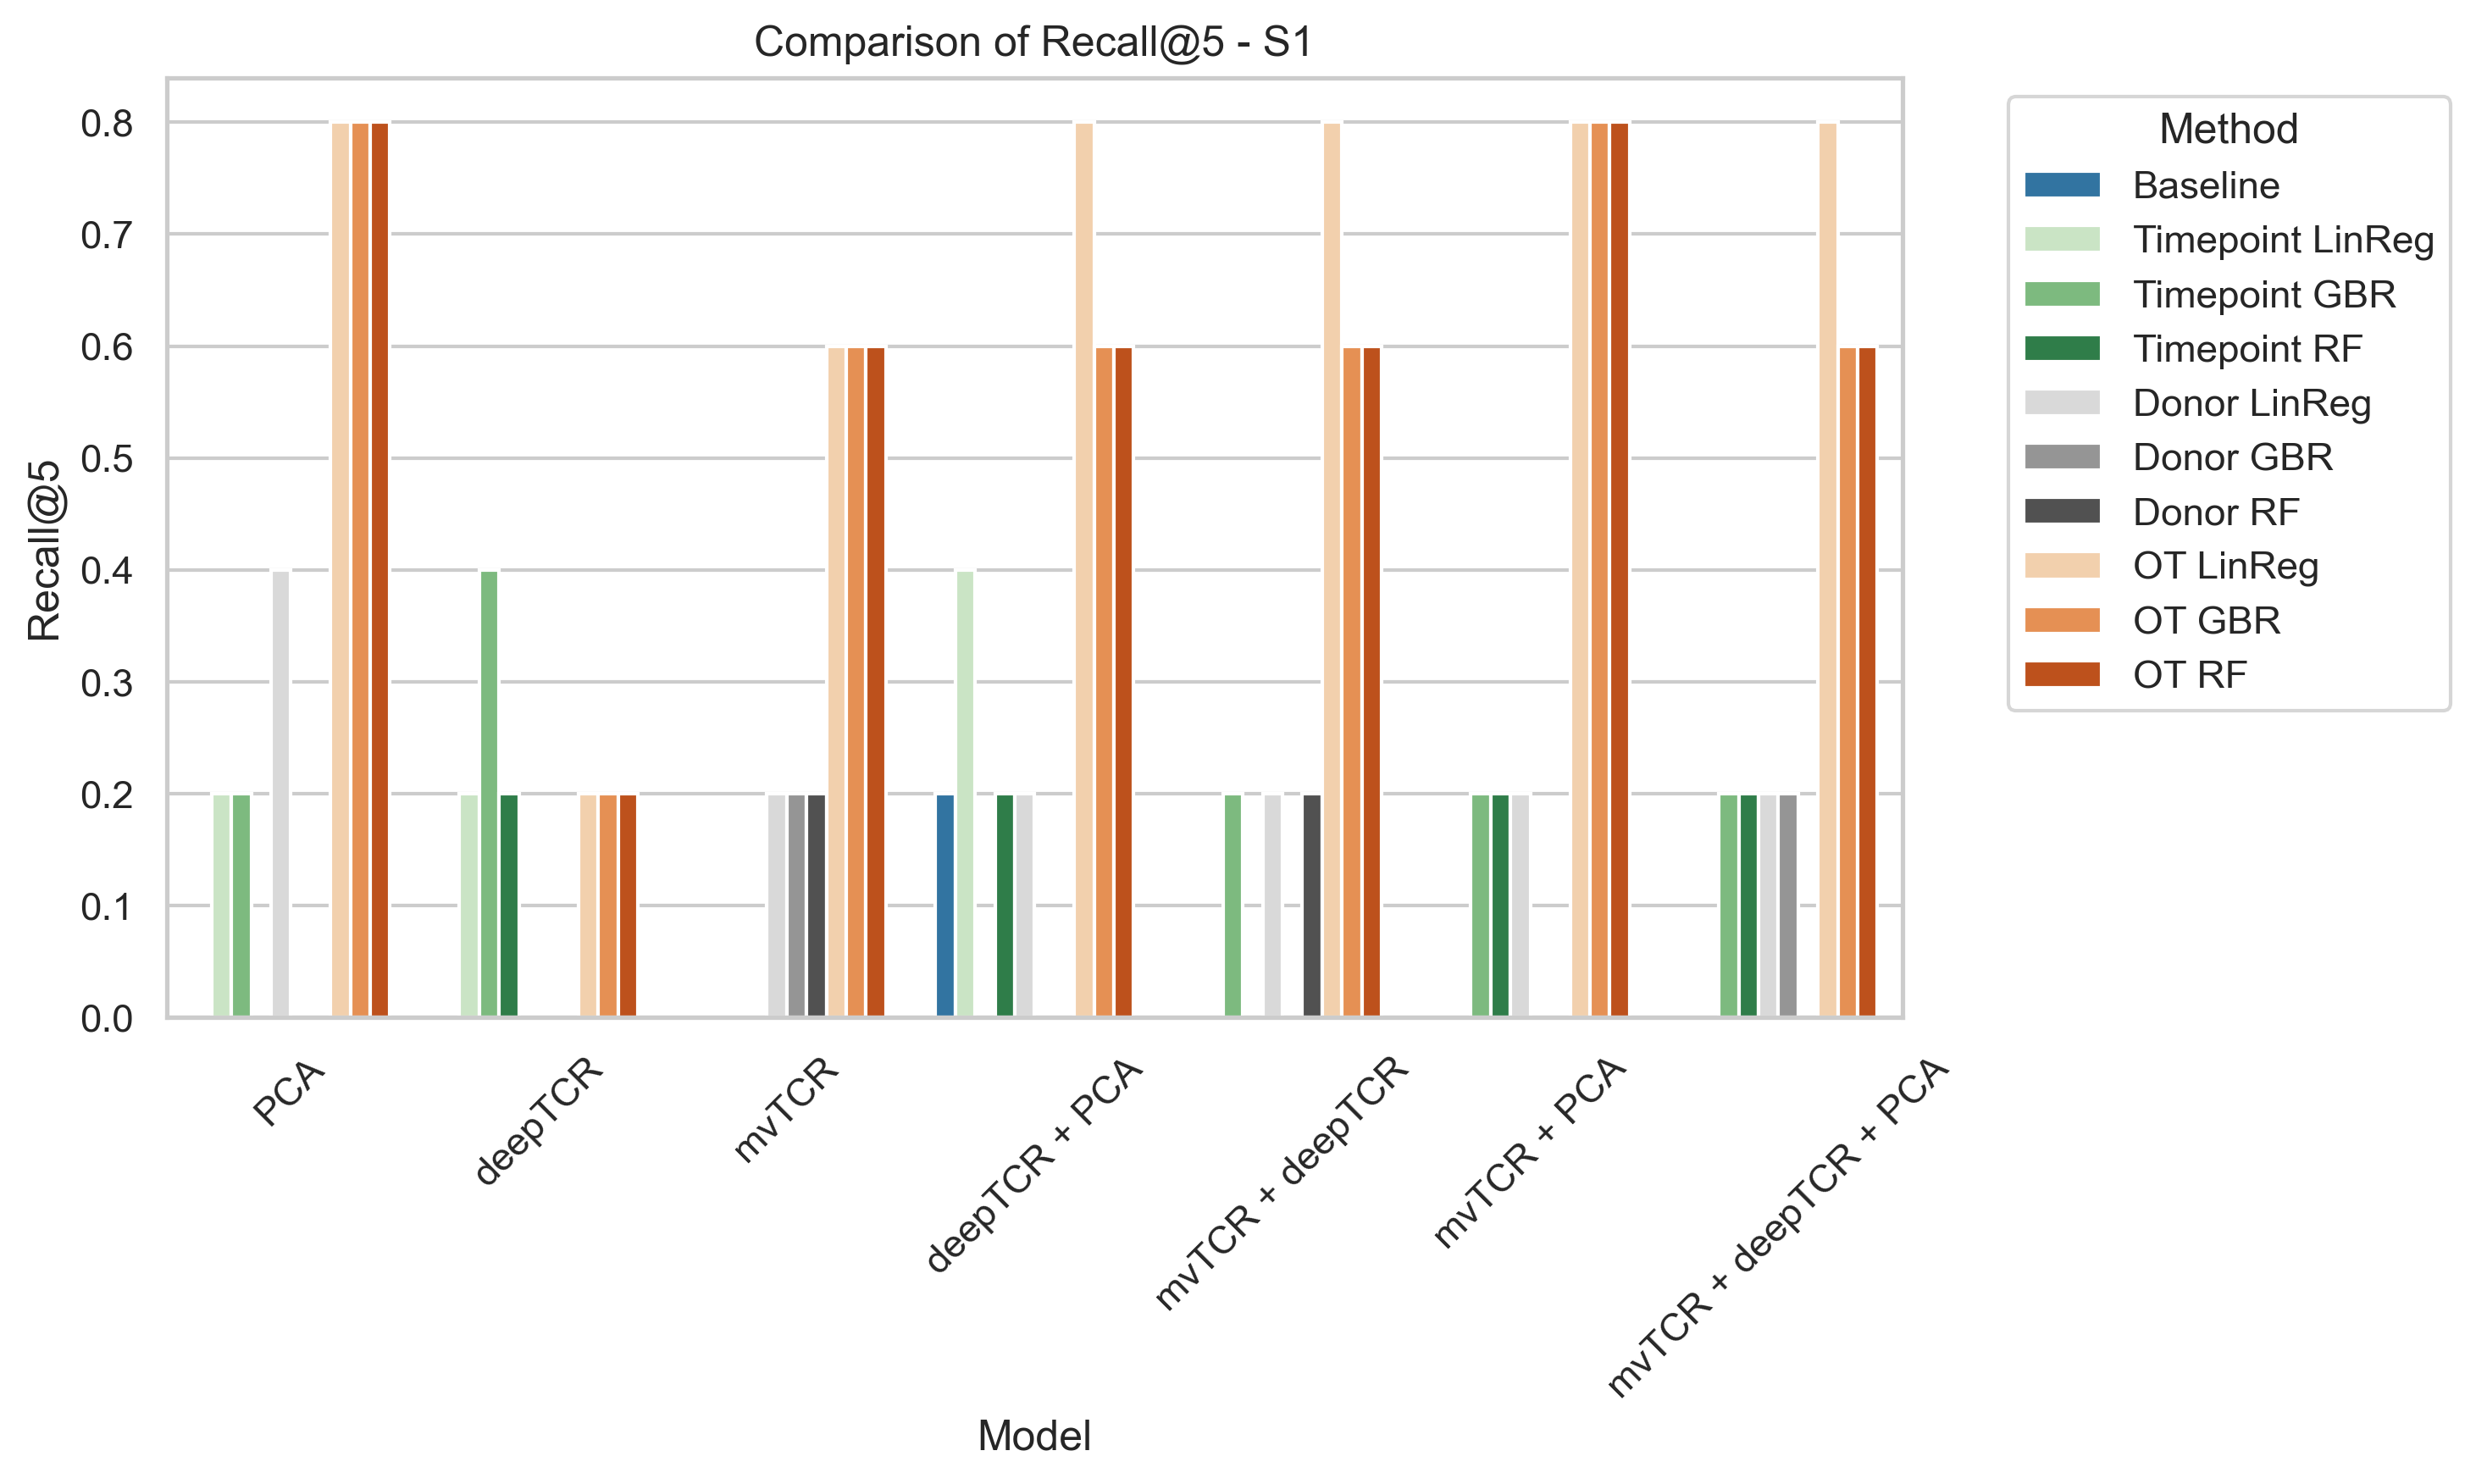

/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureW

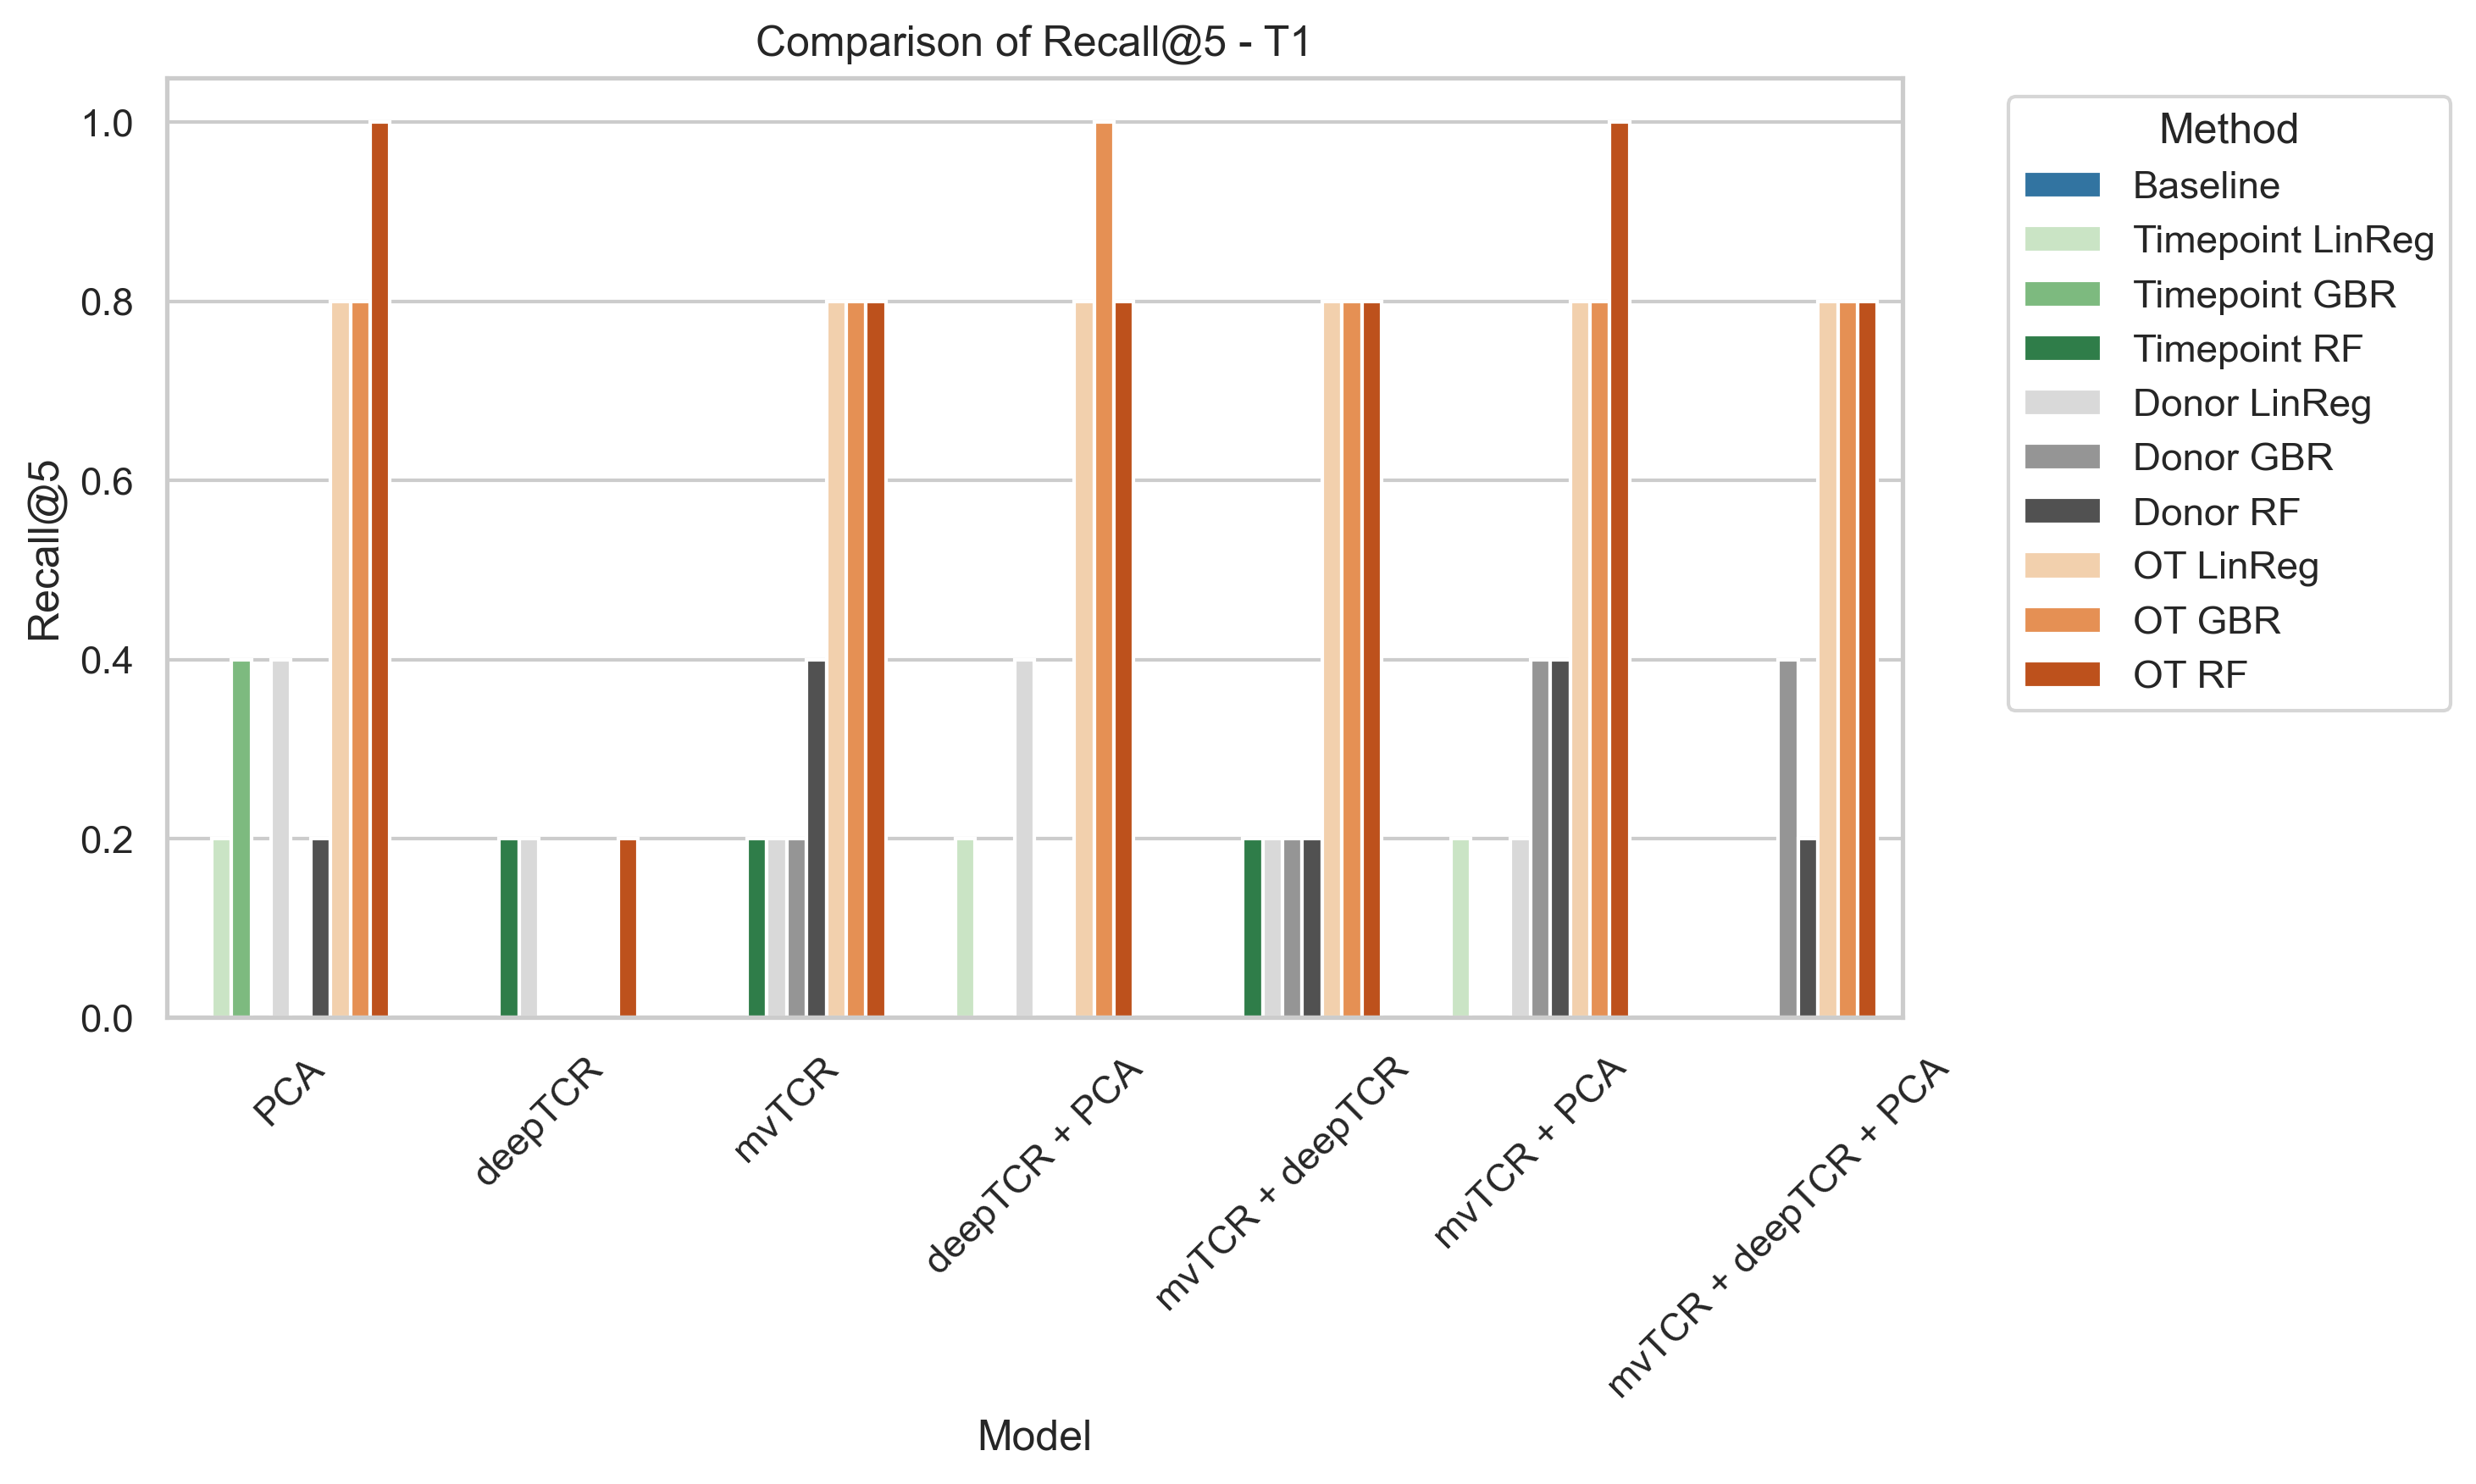

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_S1, 
    x='Model', 
    y='Value', 
    hue='Method',
    palette=color_dict
)
plt.title('Comparison of Recall@5 - S1')
plt.xlabel('Model')
plt.ylabel('Recall@5')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Repeat for T1
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_T1, 
    x='Model', 
    y='Value', 
    hue='Method',
    palette=color_dict
)
plt.title('Comparison of Recall@5 - T1')
plt.xlabel('Model')
plt.ylabel('Recall@5')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [128]:
# Filter rows where Metric == 'MSE'
df_mse = df[df['Metric'] == 'MSE']

# Split by timepoint
df_S1 = df_mse[df_mse['Timepoint'] == 'S1']
df_T1 = df_mse[df_mse['Timepoint'] == 'T1']


/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureW

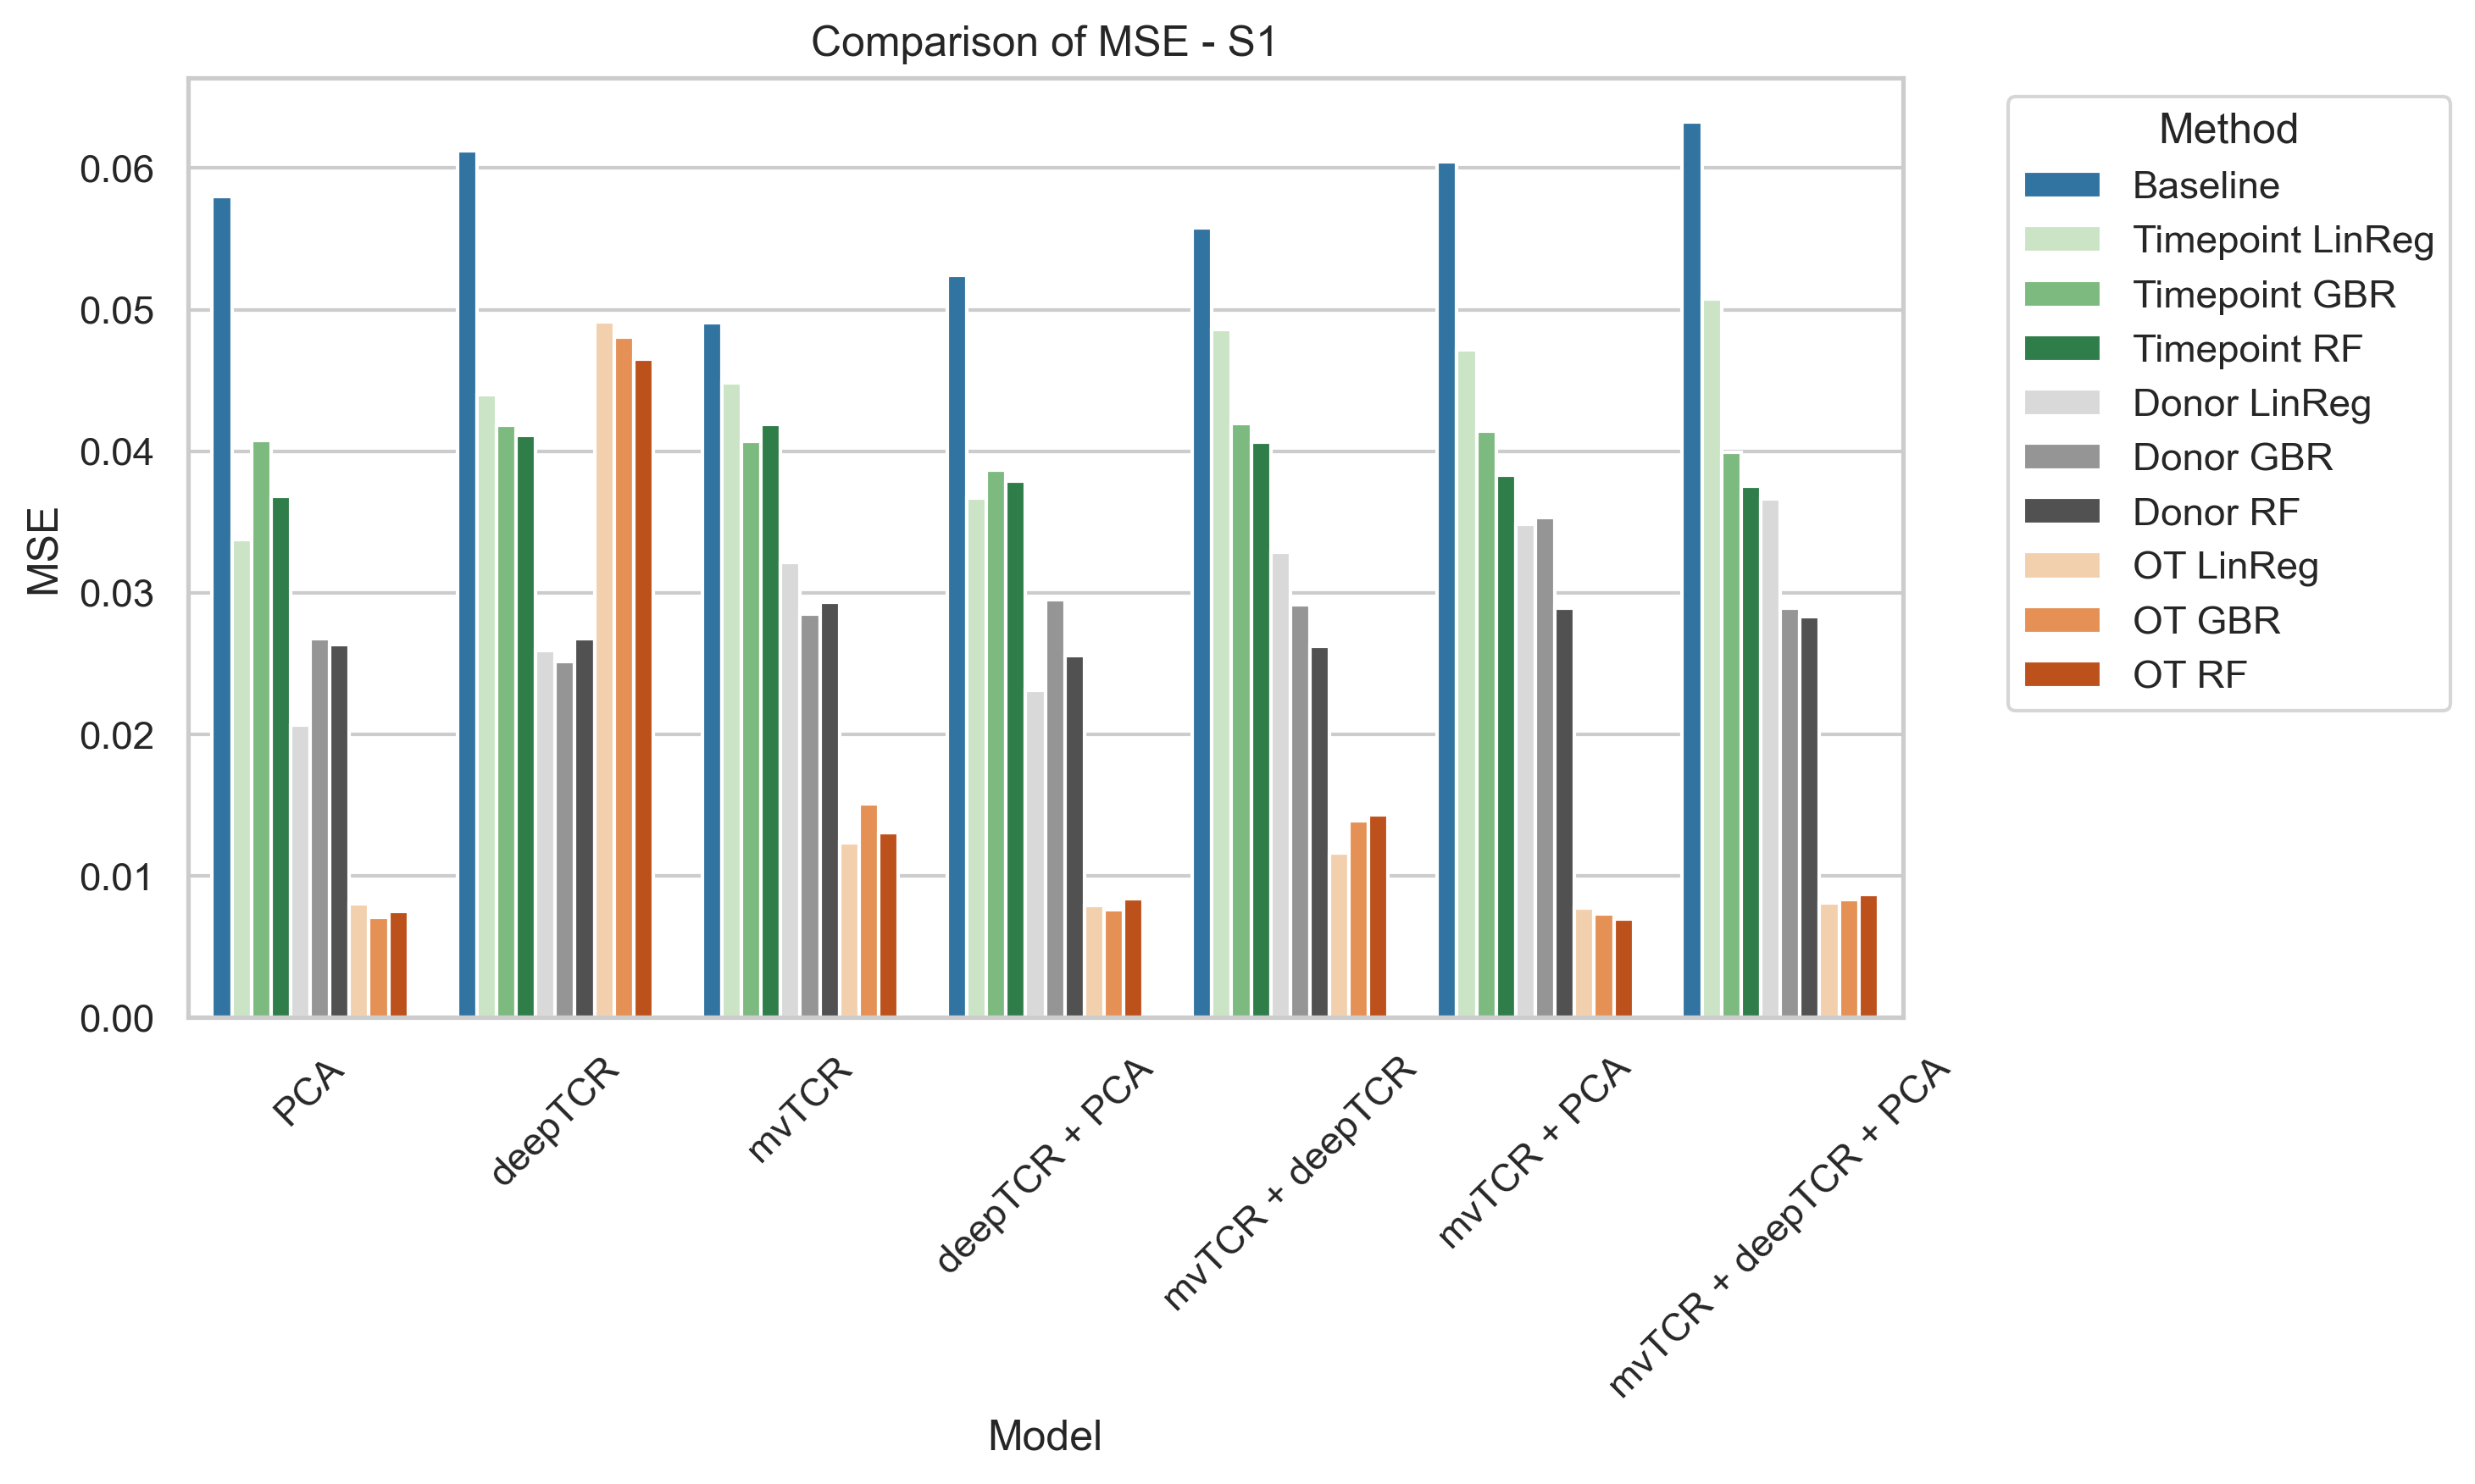

In [129]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_S1, 
    x='Model', 
    y='Value', 
    hue='Method',
    errorbar=None,  # or some function if you have repeated measures
    palette=color_dict
)
plt.title('Comparison of MSE - S1')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureW

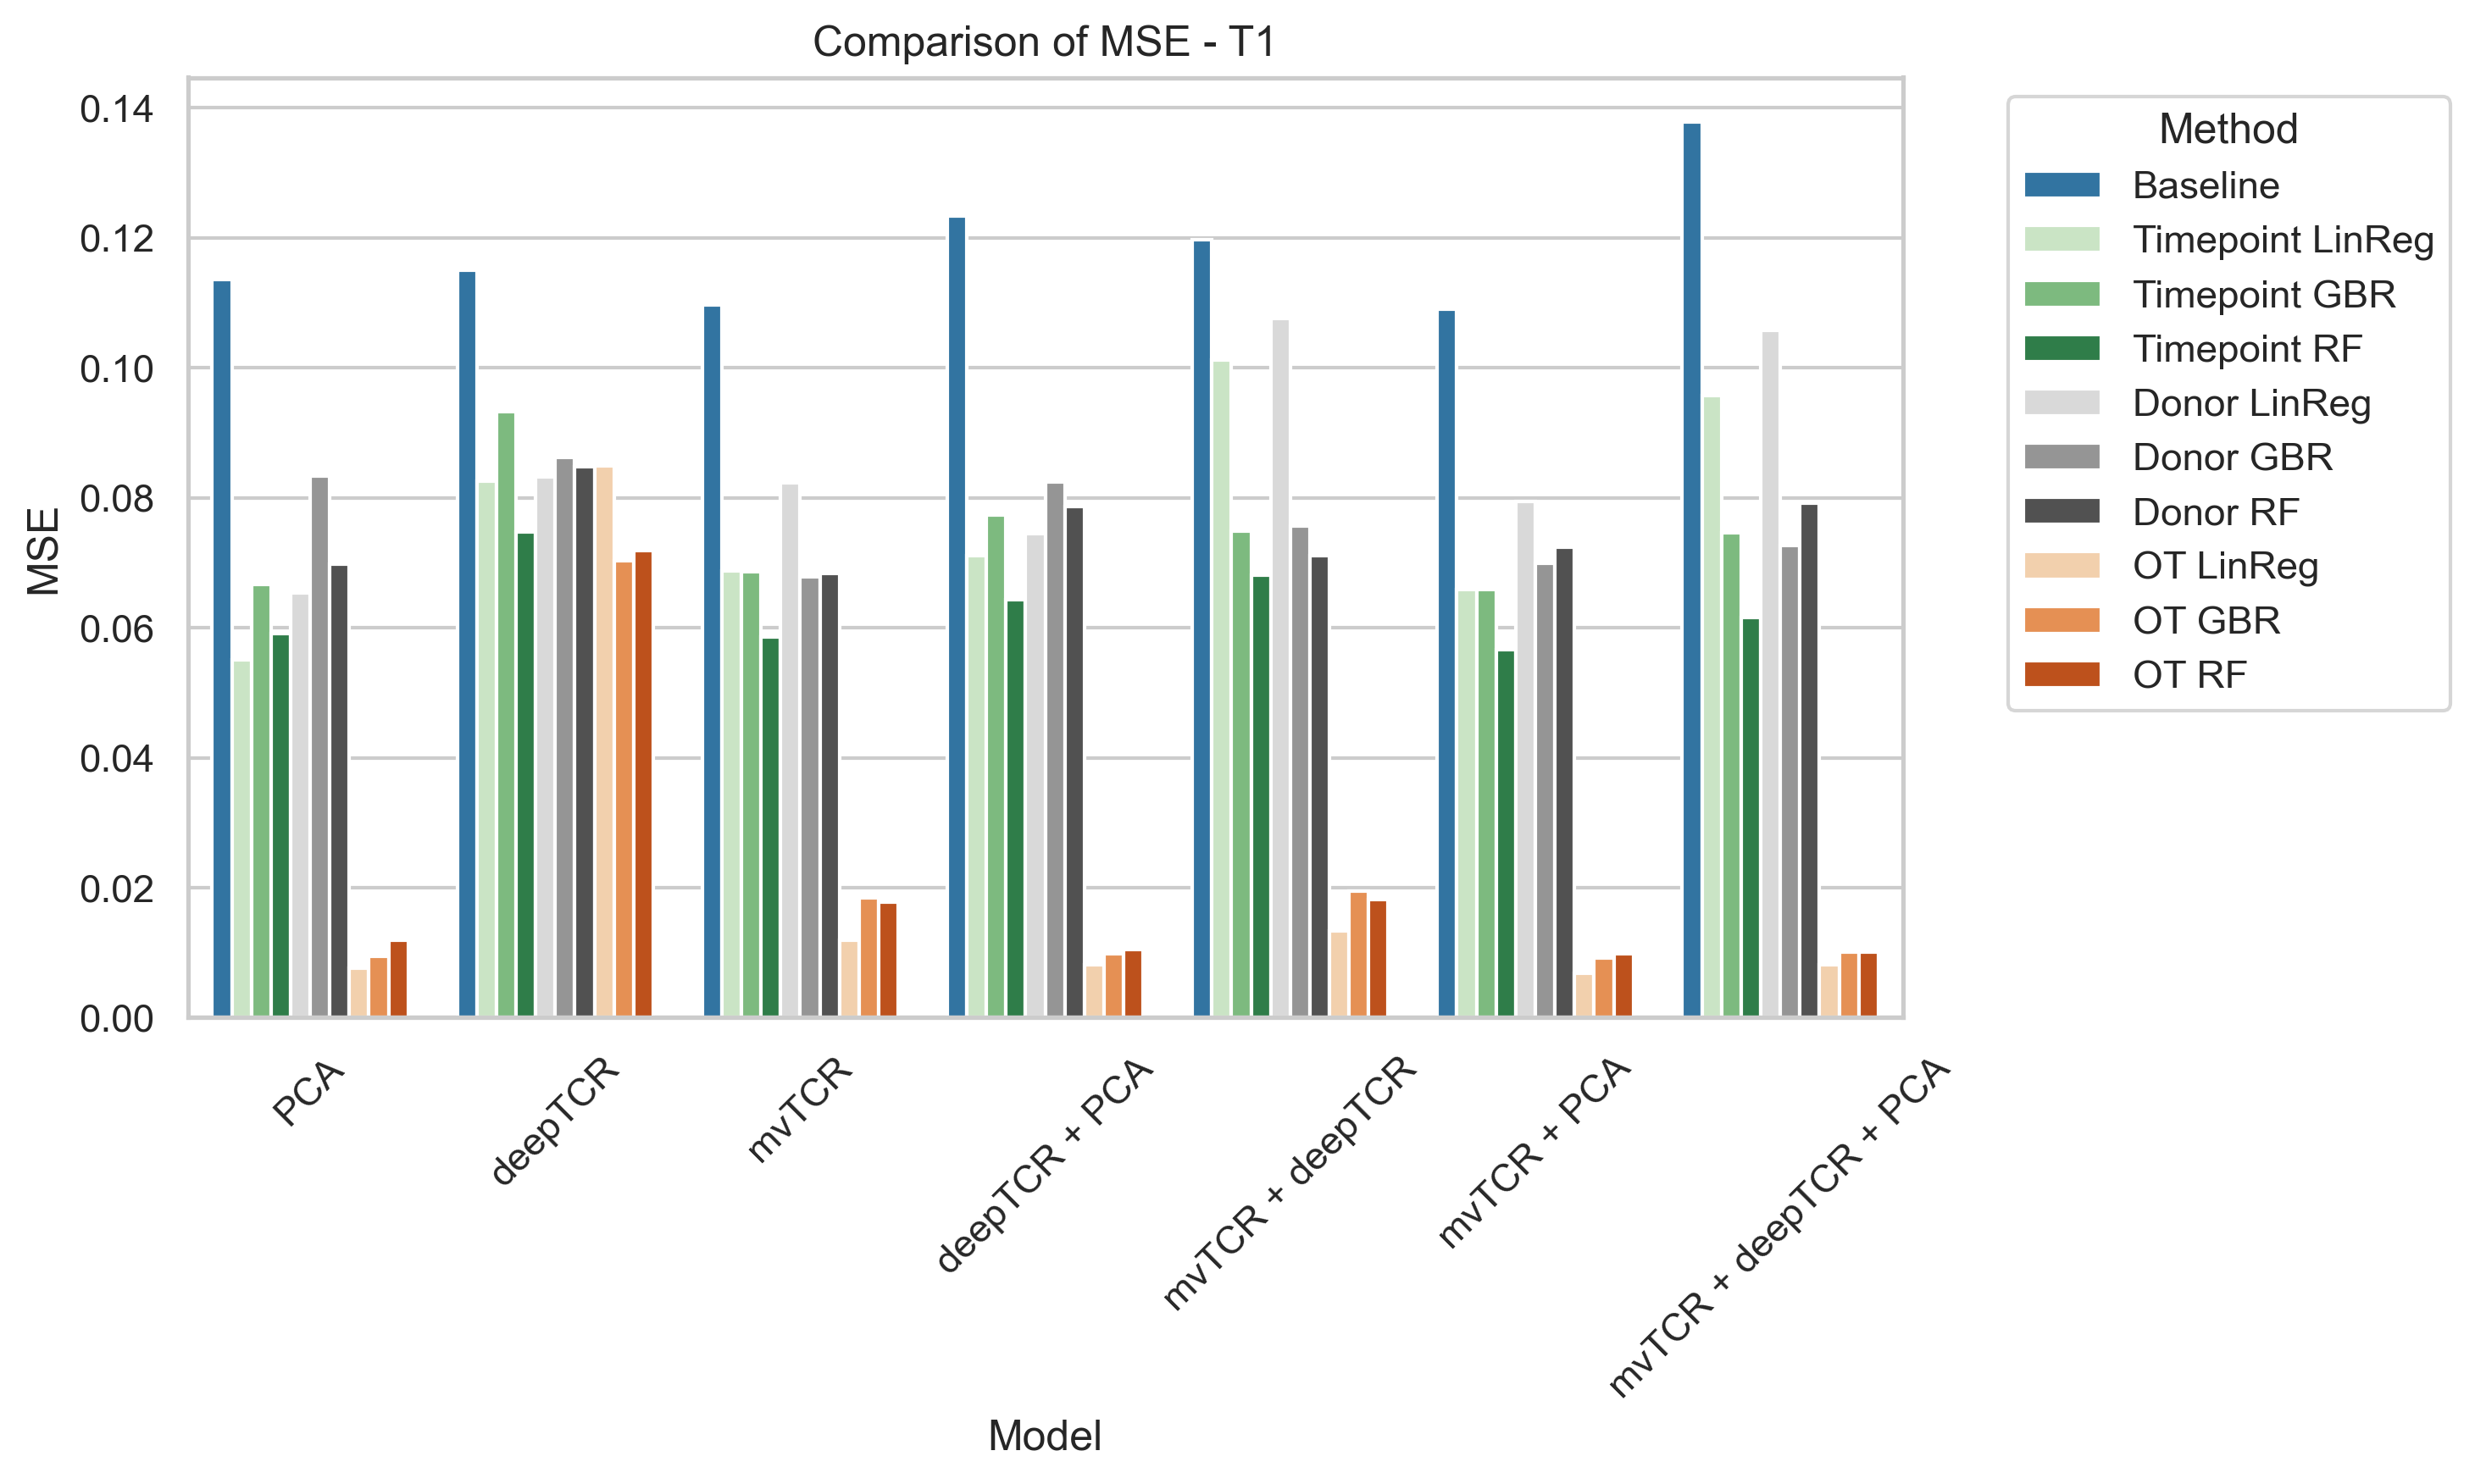

In [130]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_T1, 
    x='Model', 
    y='Value', 
    hue='Method', 
    palette=color_dict
)
plt.title('Comparison of MSE - T1')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [131]:
# Keep only rows where Metric == 'MSE for top 25% (high-responding clones)'
df_mse_top25 = df[df['Metric'] == 'MSE for top 25% (high-responding clones)']

# Separate by timepoint
df_S1 = df_mse_top25[df_mse_top25['Timepoint'] == 'S1']
df_T1 = df_mse_top25[df_mse_top25['Timepoint'] == 'T1']


/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureW

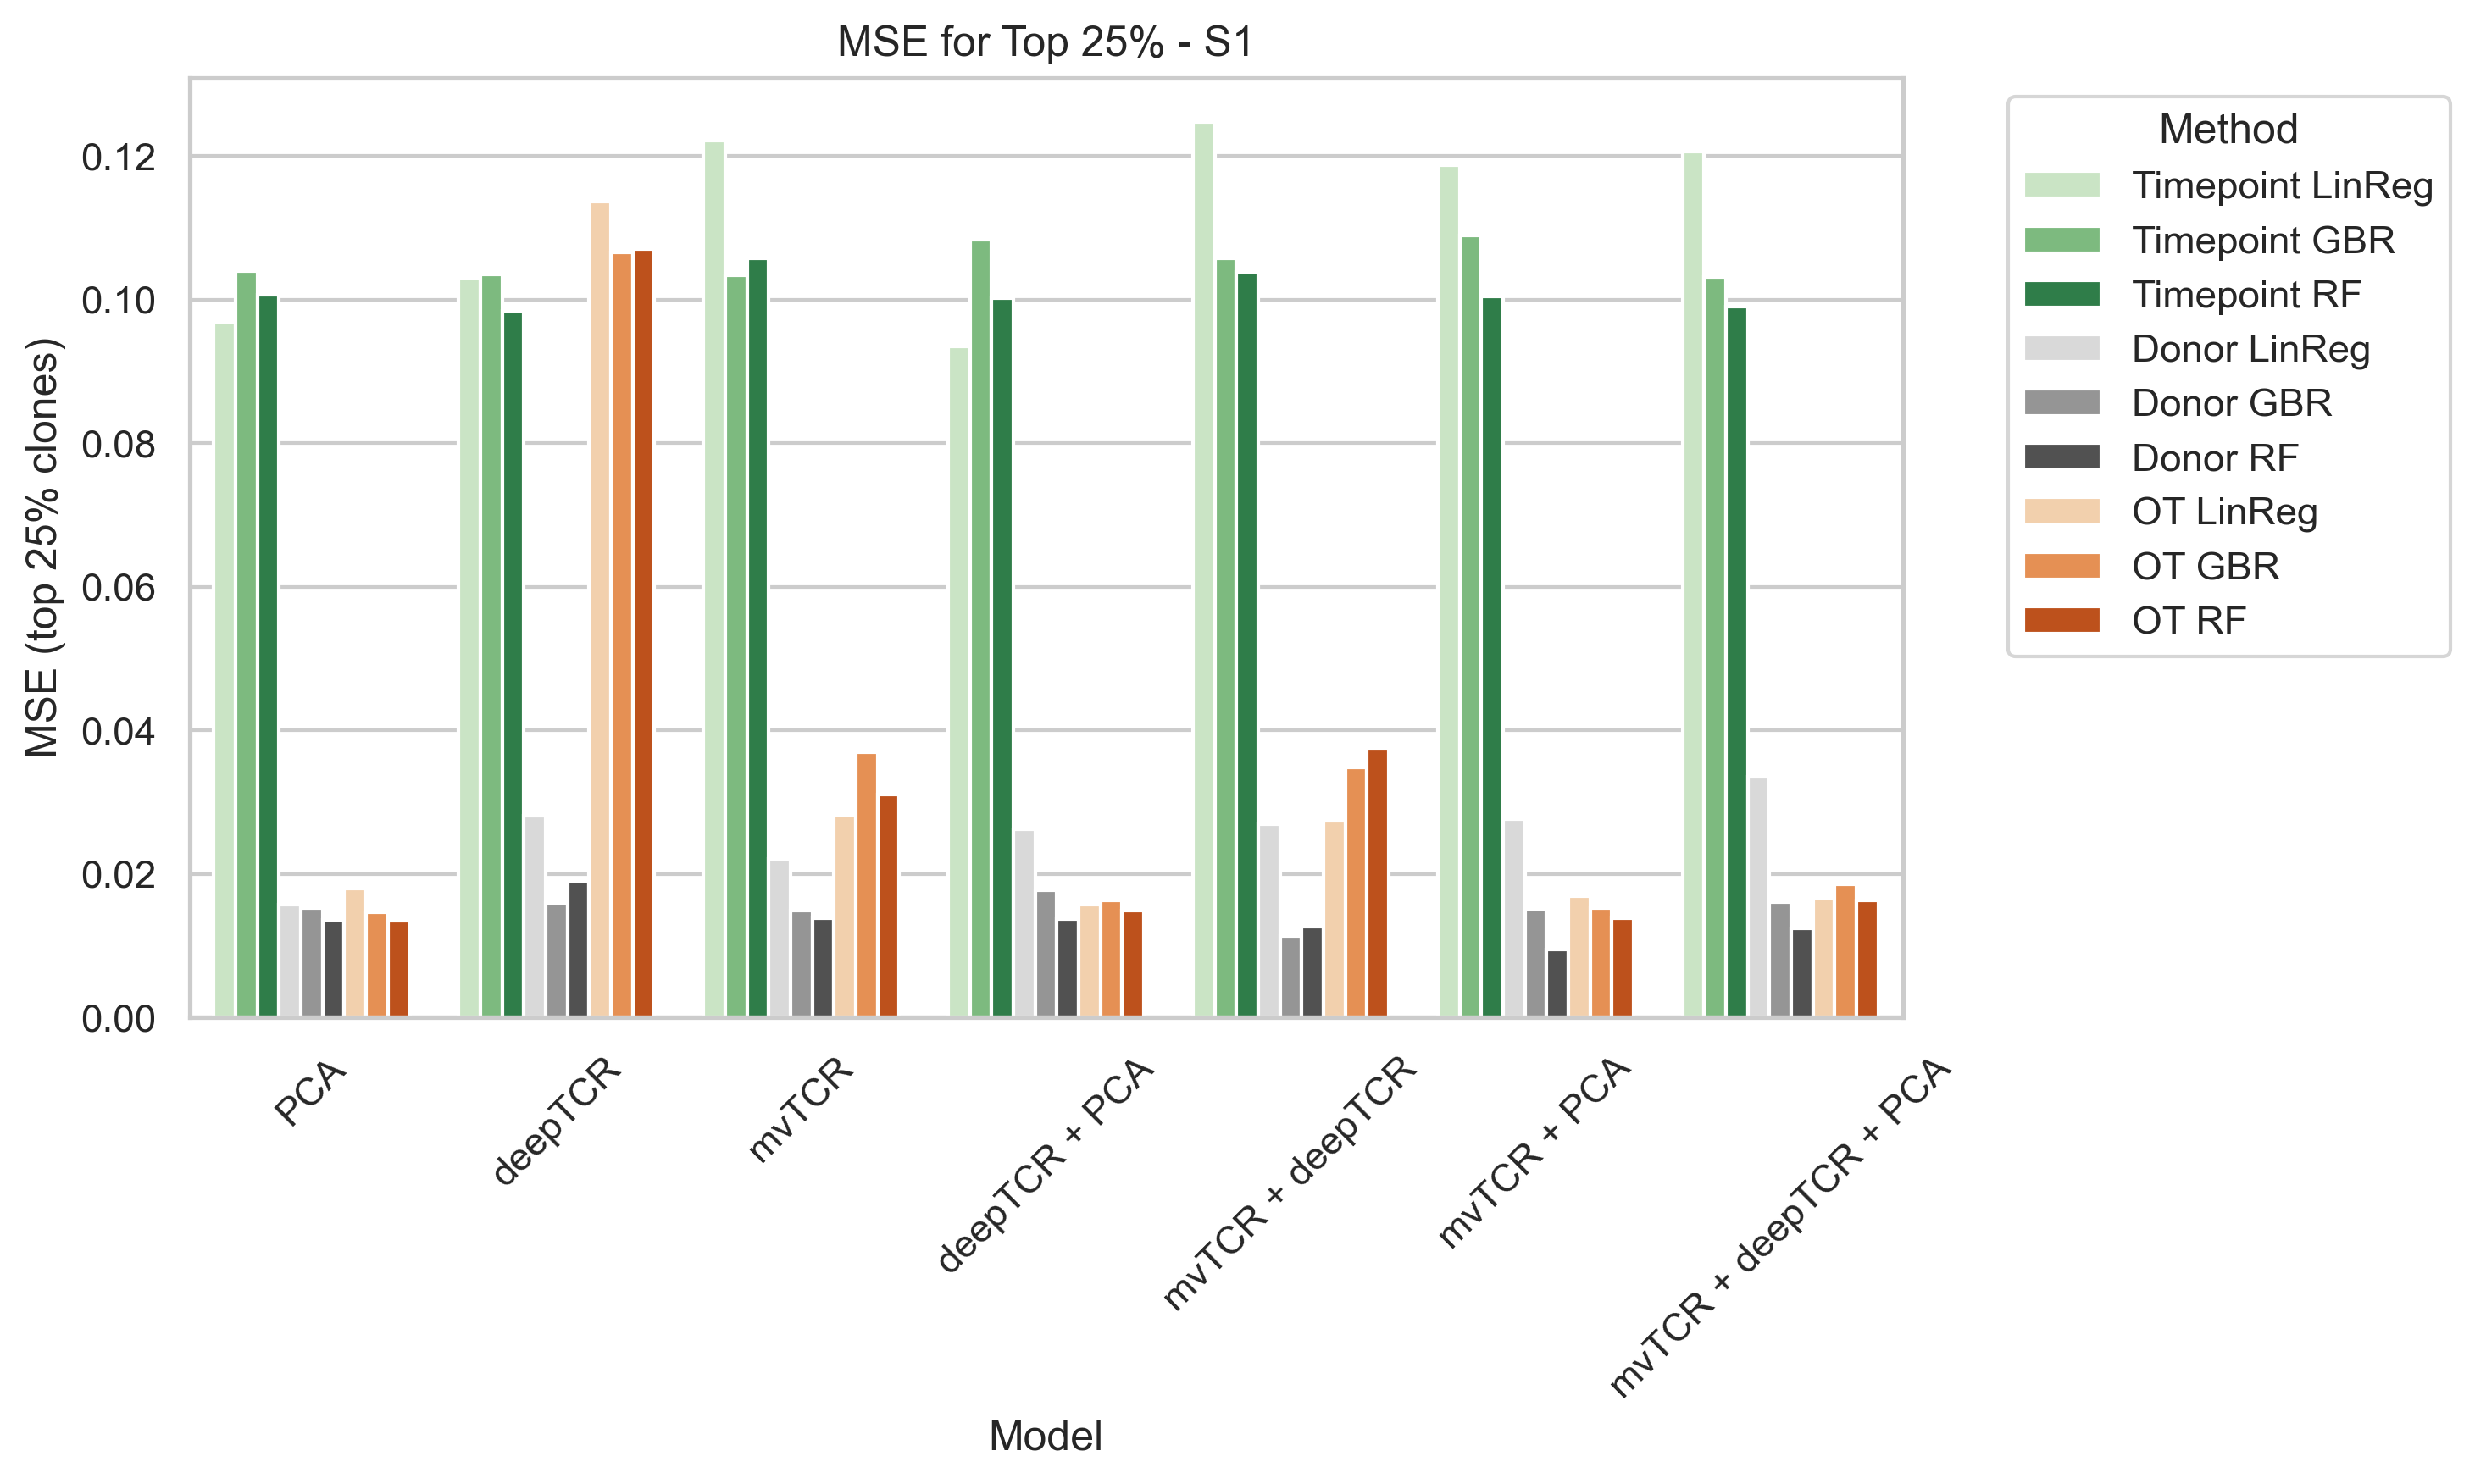

In [132]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_S1, 
    x='Model', 
    y='Value', 
    hue='Method',
    palette=color_dict
)
plt.title('MSE for Top 25% - S1')
plt.xlabel('Model')
plt.ylabel('MSE (top 25% clones)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/tristanaretz/mambaforge/envs/vaccineSimulator/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureW

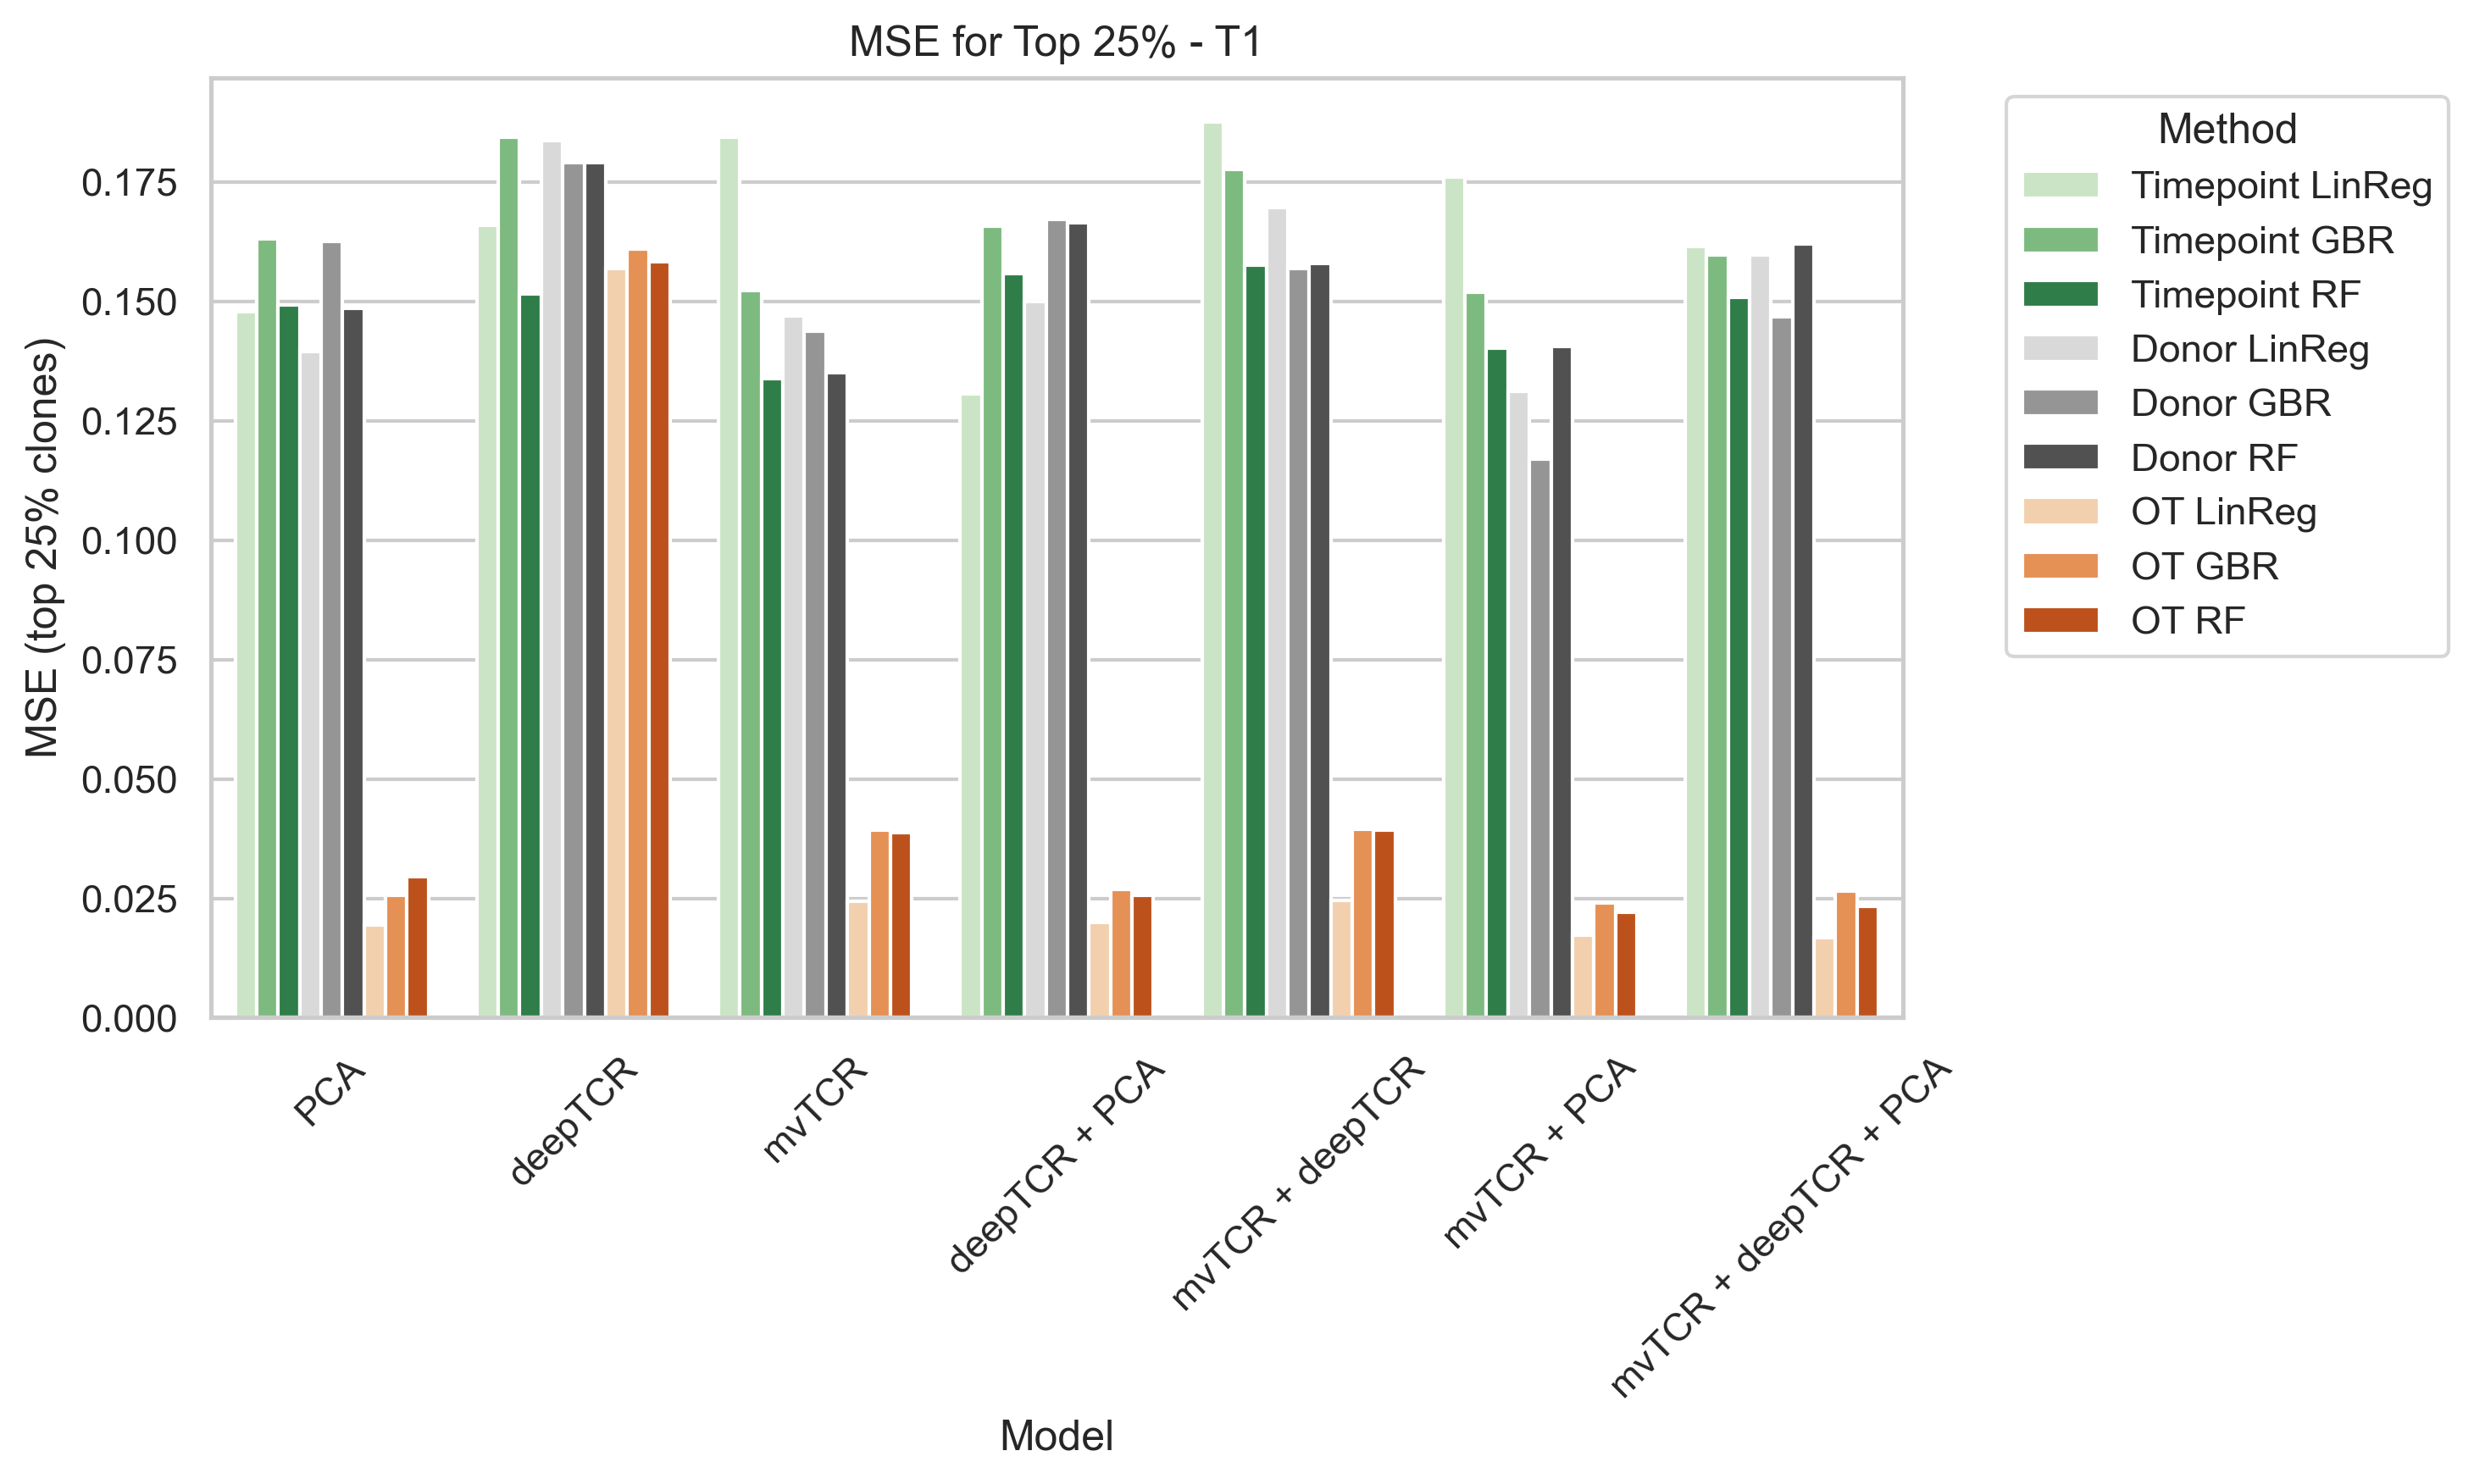

In [133]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_T1, 
    x='Model', 
    y='Value', 
    hue='Method',
    palette=color_dict
)
plt.title('MSE for Top 25% - T1')
plt.xlabel('Model')
plt.ylabel('MSE (top 25% clones)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
